In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from sklearn.linear_model import LinearRegression
from tifffile import imread
# import utils as ut

In [2]:
def get_D_alpha(traj, min_length=10, numPoints=5):
    if traj.shape[0]<min_length:
        return np.nan, np.nan, np.nan, np.nan,np.nan
    model = LinearRegression()
    x = np.log10(traj.loc[traj.correction=="corrected","lags(s)"])
    y = np.log10(traj.loc[traj.correction=="corrected","MSD(µm^2)"])
    sampleWeight = traj.loc[traj.correction=="corrected","weight"]
    #print(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints], sampleWeight.to_numpy()[:numPoints])
    model.fit(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints])#, sample_weight = sampleWeight.to_numpy()[:numPoints])
    y_pred = model.predict(x.to_numpy().reshape(-1,1))
    return model.intercept_, model.coef_[0],traj.iloc[0].treatment,traj.iloc[0].file,traj.iloc[0].channel#10**y_pred,10**x

In [3]:
labels = 15
legend_title = labels +1
sns.set_context("paper", font_scale=1.5)#rc={"font.size":labels,"axes.titlesize":labels,"axes.labelsize":labels,"legend.fontsize":labels,"legend.title_fontsize":legend_title,""})  

# Open all the data

In [4]:
list_files_cor = glob.glob('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/*/msd_corrected__*')
list_files_uncor = glob.glob('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/*/msd_uncorrected__*')

In [5]:
list_files = list_files_cor + list_files_uncor

In [6]:
list_files_cor

['/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20220907_Rad21-Halo_SPT_2D5_Sororin_noaux_40mW_2/msd_corrected__20220907_Rad21-Halo_SPT_2D5_Sororin_noaux_40mW_2.csv',
 '/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230605_Rad21-Halo_G6_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/msd_corrected__20230605_Rad21-Halo_G6_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
 '/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/msd_corrected__20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
 '/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230529_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/msd_corrected__20230529_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
 '/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mChe

In [7]:
for i in list_files:
    if 'uncorrected' in i:
        print(i)

/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20220907_Rad21-Halo_SPT_2D5_Sororin_noaux_40mW_2/msd_uncorrected__20220907_Rad21-Halo_SPT_2D5_Sororin_noaux_40mW_2.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230605_Rad21-Halo_G6_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/msd_uncorrected__20230605_Rad21-Halo_G6_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/msd_uncorrected__20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230529_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/msd_uncorrected__20230529_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWith

In [8]:
df_list = []
for file in list_files:
    if 'test_tracking_without_gaps' in file:
        print(file)
        continue
    df = pd.read_csv(file)
    df.tamsd = df.tamsd*(0.16**2) # from pixel to µm
    df.lags = df.lags*10 # from frame to seconds
    df.tamsd = df.tamsd - (2*(0.035**2)) # subtract the localization error
    df.rename(columns={'tamsd':'MSD(µm^2)','lags':'lags(s)'}, inplace=True)

    if 'NIPBL' in file:
        df['cell_type'] = ['NIPBL']*len(df)
    if 'sororin' in file or 'Sororin' in file:
        df['cell_type'] = ['sororin']*len(df)
    if 'G6' in file:
        df['cell_type'] = ['WT']*len(df)
        df['treatment'] = ['untreated']*len(df)
    
    if '6h' in file or '3h' in file:
        df['treatment'] = ['treated']*len(df)
    if '0h' in file:
        df['treatment'] = ['untreated']*len(df)
    if '40mW' in file:
        df['treatment'] = ['untreated']*len(df)
    
    if 'corrected' in file:
        df['correction'] = ['corrected']*len(df)
    if 'uncorrected' in file:
        df['correction'] = ['uncorrected']*len(df)


    df['file'] = [file.split('/')[7]]*len(df)
    df.replace('w1','cohesin', inplace=True)
    df.replace('w2','DNA', inplace=True)
    df_list.append(df)

df_combined = pd.concat(df_list)


In [9]:
df_NIPBL_treated = df_combined[(df_combined['cell_type']=='NIPBL') & (df_combined['treatment']=='treated')].copy(deep=True)
df_NIPBL_untreated = df_combined[(df_combined['cell_type']=='NIPBL') & (df_combined['treatment']=='untreated')].copy(deep=True)
df_sororin_treated = df_combined[(df_combined['cell_type']=='sororin') & (df_combined['treatment']=='treated')].copy(deep=True)
df_sororin_untreated = df_combined[(df_combined['cell_type']=='sororin') & (df_combined['treatment']=='untreated')].copy(deep=True)
df_wt = df_combined[(df_combined['cell_type']=='WT') & (df_combined['treatment']=='untreated')].copy(deep=True)

In [10]:
df_NIPBL = pd.concat([df_NIPBL_treated,df_NIPBL_untreated])
df_NIPBL = df_NIPBL[df_NIPBL.correction == 'corrected']

df_sororin = pd.concat([df_sororin_treated,df_sororin_untreated])
df_sororin = df_sororin[df_sororin.correction == 'corrected']

df_treated = pd.concat([df_NIPBL_treated,df_sororin_treated])
df_treated = df_treated[df_treated.correction == 'corrected']

df_untreated = pd.concat([df_NIPBL_untreated,df_sororin_untreated,df_wt])
df_untreated = df_untreated[df_untreated.correction == 'corrected']

# compute the fits for all data

In [11]:
df_wt_cor = df_wt[df_wt.correction == 'corrected']

In [12]:
coefficients_nip = df_NIPBL.groupby(by="uniqueid").apply(get_D_alpha, min_length=10, numPoints=5).to_frame()
coefficients_sor = df_sororin.groupby(by="uniqueid").apply(get_D_alpha, min_length=10, numPoints=5).to_frame()
coefficients_wt = df_wt_cor.groupby(by="uniqueid").apply(get_D_alpha, min_length=10, numPoints=5).to_frame()

In [13]:
for coefficients in [coefficients_nip,coefficients_sor,coefficients_wt]:
    coefficients['D(µm^2/s)'], coefficients['α'], coefficients['treatment'], coefficients['file'],coefficients['channel'] = zip(*coefficients.iloc[:,0])
    coefficients['D(µm^2/s)'] = 10**coefficients['D(µm^2/s)']
    coefficients.drop(columns=[0],inplace=True)

In [14]:
coefficients_sor['Cell type'] = ['sororin']*len(coefficients_sor)
coefficients_nip['Cell type'] = ['NIPBL']*len(coefficients_nip)
coefficients_wt['Cell type'] = ['WT']*len(coefficients_wt)

In [15]:
coefficients = pd.concat([coefficients_sor,coefficients_nip,coefficients_wt])

In [16]:
D = 'D(µm^2/s)'
alpha = 'α'

# figure 5

In [25]:
coefficients_untreated_DNA = coefficients[(coefficients.treatment == 'untreated')&(coefficients.channel == 'DNA')]

In [26]:
df_comb_DNA = pd.concat([df_NIPBL[df_NIPBL.channel == 'DNA'],df_sororin[df_sororin.channel == 'DNA'],df_wt[(df_wt.channel == 'DNA')&(df_wt.correction == 'corrected')]])
df_comb_DNA = df_comb_DNA[df_comb_DNA.treatment == 'untreated']
df_comb_DNA.rename(columns={'cell_type':'Cell type'},inplace=True)

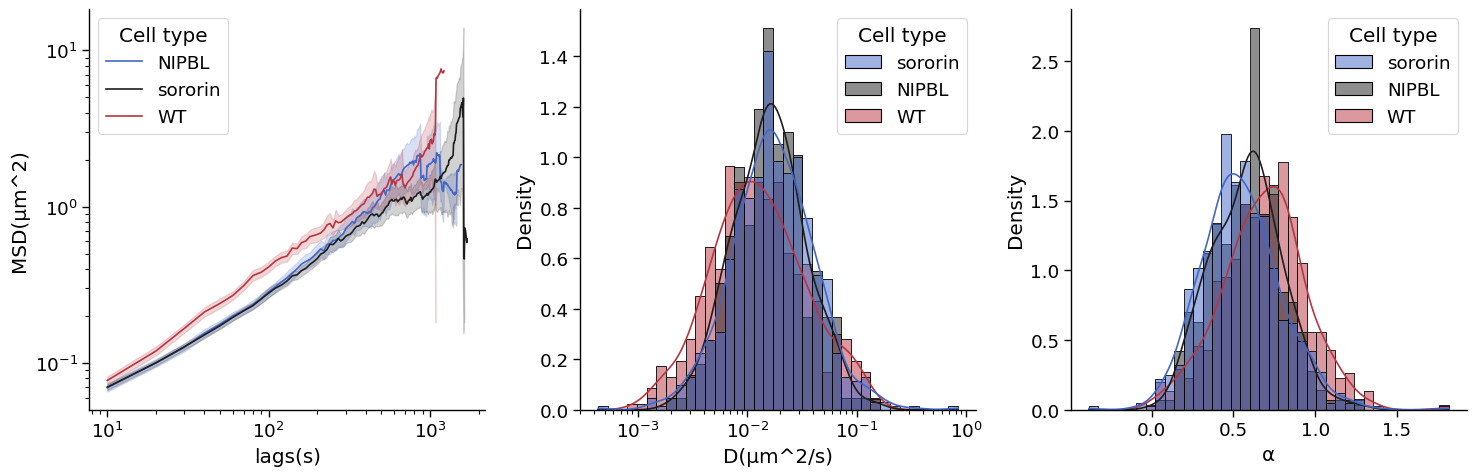

In [63]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
palette ='icefire'
sns.histplot(data=coefficients_untreated_DNA, x=D, hue='Cell type', kde=True,fill=True, palette=palette,common_norm=False,log_scale=True,ax = ax[1],stat='density')
sns.histplot(data=coefficients_untreated_DNA, x=alpha, hue='Cell type', kde=True, fill=True, palette=palette,common_norm=False,ax = ax[2],stat='density')
sns.lineplot(data=df_comb_DNA,x='lags(s)', y='MSD(µm^2)',hue='Cell type',palette=palette,ax=ax[0])

ax[0].set_yscale('log')
ax[0].set_xscale('log')
sns.despine(top=True,right=True)

fig.tight_layout()
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/master_thesis/plots/DNA_msd.pdf',transparent=True)

In [75]:
df_track = pd.read_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv')
labels_im = np.load('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/new_labels__20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB__w2.npy')

In [68]:
a = df_track[(df_track.label == 7)&(df_track.channel == 'w2')].groupby('track_id').count().sort_values('x',ascending=False).index.values[:9]
track_w2 = df_track[df_track.track_id.isin(a)]
tracks_w2 = track_w2[track_w2.channel == "w2"]

In [112]:
labels = 15
legend_title = labels +1
sns.set_context("paper", font_scale=1.5)#rc={"font.size":labels,"axes.titlesize":labels,"axes.labelsize":labels,"legend.fontsize":labels,"legend.title_fontsize":legend_title,""})  

In [79]:
path_tracks_unc = ['/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
'/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv']

df_list = []

for path in path_tracks_unc:
    df = pd.read_csv(path)
    df['file'] = [path.split('/')[7]] * len(df)
    df_list.append(df)

df_tracks_unc = pd.concat(df_list)
df_tracks_unc = df_tracks_unc[df_tracks_unc.channel == 'w2']

In [81]:
df_tracks_unc = ut.filter_tracks(df_tracks_unc)
df_unc_w2_msd_rad = ut.calculate_all_pairwise_tamsd(df_tracks_unc,radial=True)

In [82]:
df_unc_w2_msd_rad.lags = df_unc_w2_msd_rad.lags*10
df_unc_w2_msd_rad.tamsd = df_unc_w2_msd_rad.tamsd*(0.16**2)
df_unc_w2_msd_rad.tamsd = df_unc_w2_msd_rad.tamsd - (2*(0.035**2))

In [92]:
msd_cor = df_untreated[(df_untreated.correction == 'corrected') & (df_untreated.channel == 'DNA') & (df_untreated.cell_type == 'NIPBL')].copy(deep=True)
msd_cor['type'] = ['Corrected MSD']*len(msd_cor)
msd_cor = msd_cor[['lags(s)','MSD(µm^2)','type']]

In [93]:
df_unc_w2_msd_rad['type'] = ['Uncorrected radial MSD']*len(df_unc_w2_msd_rad)
df_unc_w2_msd_rad.rename(columns={'tamsd':'MSD(µm^2)','lags':'lags(s)'}, inplace=True)

In [94]:
df_unc_w2_msd_rad = df_unc_w2_msd_rad[['lags(s)','MSD(µm^2)','type']]

In [95]:
df_comb_correction = pd.concat([df_unc_w2_msd_rad,msd_cor])

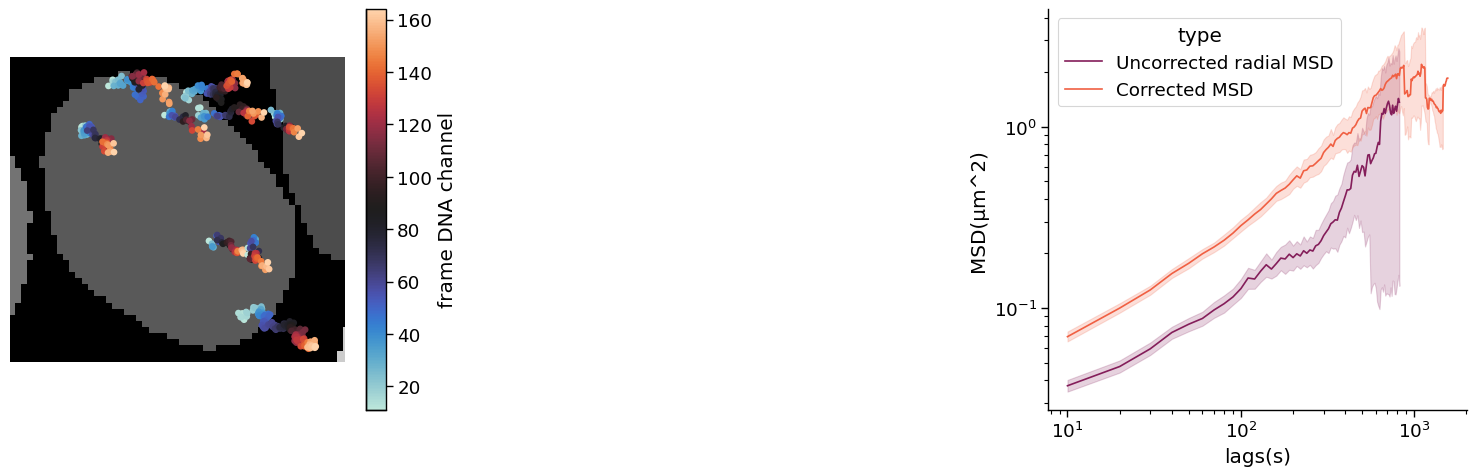

In [140]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

for j in track_w2.track_id.unique():

    t2 = tracks_w2[tracks_w2.track_id == j]

    b = ax[0].scatter(data=t2,x='x',y='y',c=t2.frame,cmap=palette,linewidth=0,zorder=2)
    ax[0].plot(t2.x,t2.y,c="dimgray",zorder=1)

    ax[0].imshow(labels_im[0],cmap='gray',alpha=0.5,zorder=0,interpolation='nearest')

fig.colorbar(b,label='frame DNA channel')
ax[0].set_xlim(130,240)
ax[0].set_ylim(350,450)
ax[0].axis('off')


sns.lineplot(data=df_comb_correction,x='lags(s)', y='MSD(µm^2)',hue='type',palette='rocket',ax = ax[2])

ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[1].axis('off')

sns.despine(top=True,right=True)
plt.tight_layout()

plt.savefig('/tungstenfs/scratch/ggiorget/nessim/master_thesis/plots/DNA_tracks.pdf',transparent=True)

# Figure 6

In [27]:
coefficients_sor_DNA = coefficients_sor[coefficients_sor.channel == 'DNA']
coefficients_nip_DNA = coefficients_nip[coefficients_nip.channel == 'DNA']
NIPBL_DNA = df_NIPBL[df_NIPBL.channel == 'DNA']
sororin_DNA = df_sororin[df_sororin.channel == 'DNA']

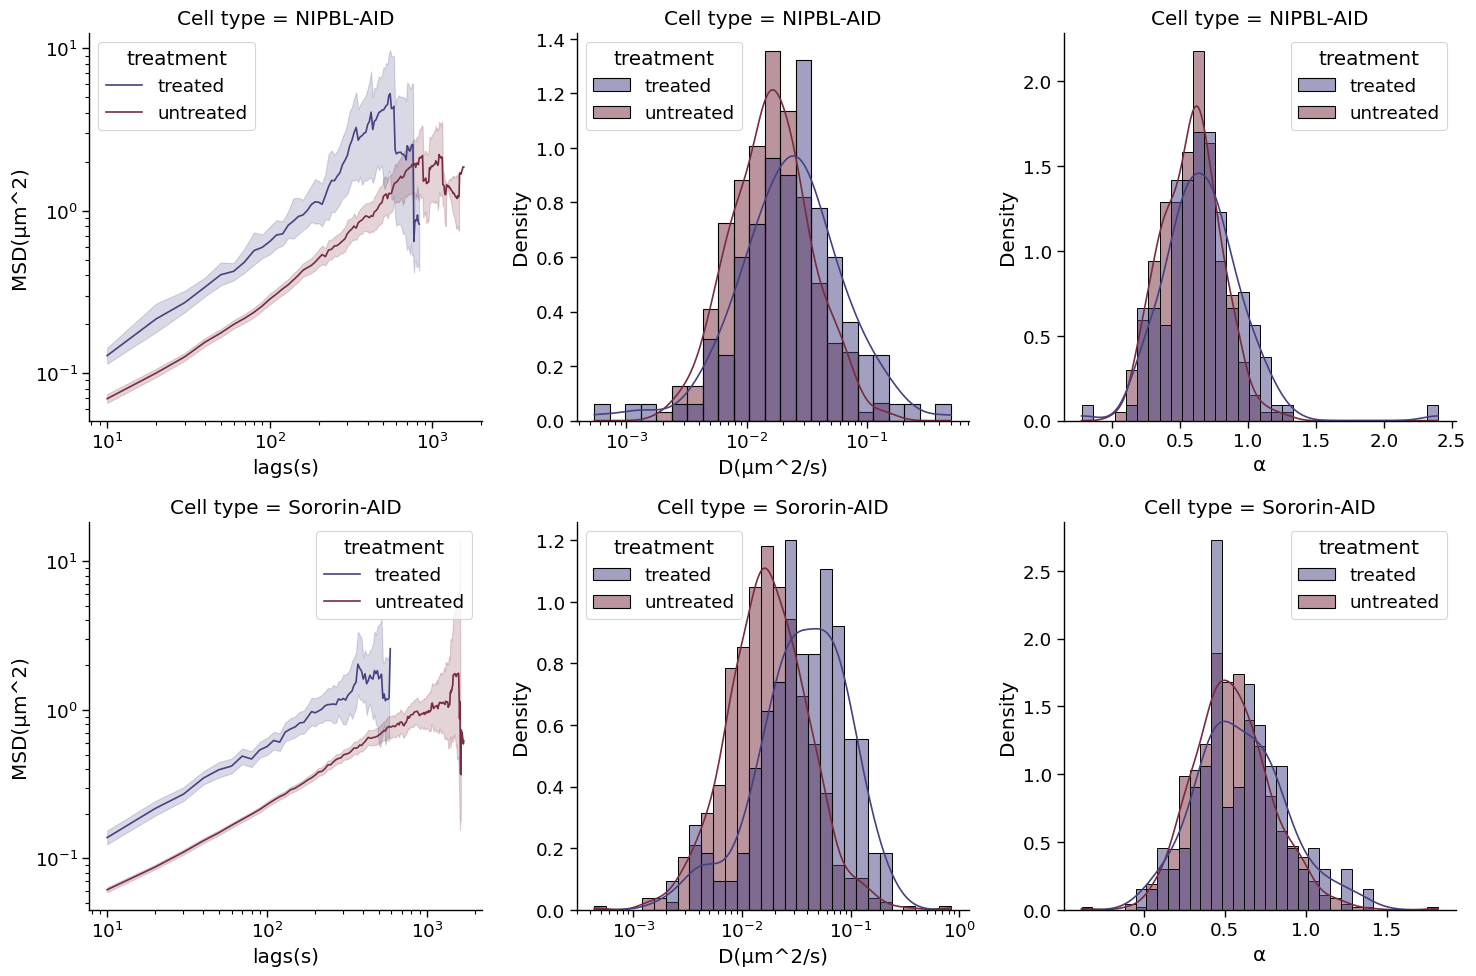

In [136]:
fig,ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.ravel()

palette ='icefire'
sns.lineplot(data=NIPBL_DNA,x='lags(s)', y='MSD(µm^2)',hue='treatment',palette=palette,ax=ax[0])
sns.histplot(data=coefficients_nip_DNA.sort_values(by='treatment'), x=D, hue='treatment', kde=True,fill=True, palette=palette,common_norm=False,log_scale=True,ax = ax[1],stat='density')
sns.histplot(data=coefficients_nip_DNA.sort_values(by='treatment'), x=alpha, hue='treatment', kde=True, fill=True, palette=palette,common_norm=False,ax = ax[2],stat='density')


ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xscale('log')

sns.lineplot(data=sororin_DNA,x='lags(s)', y='MSD(µm^2)',hue='treatment',palette=palette,ax=ax[3])
sns.histplot(data=coefficients_sor_DNA, x=D, hue='treatment', kde=True,fill=True, palette=palette,common_norm=False,log_scale=True,ax = ax[4],stat='density')
sns.histplot(data=coefficients_sor_DNA, x=alpha, hue='treatment', kde=True, fill=True, palette=palette,common_norm=False,ax = ax[5],stat='density')



for l,a in enumerate(ax):
    if l < 3:
        a.set_title('Cell type = NIPBL-AID')
    else:
        a.set_title('Cell type = Sororin-AID')

sns.despine(top=True,right=True)

fig.tight_layout()
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/master_thesis/plots/DNA_treatment.pdf',transparent=True)

# Figure 7

In [17]:
coefficients_untreated = coefficients[(coefficients.treatment == 'untreated')]

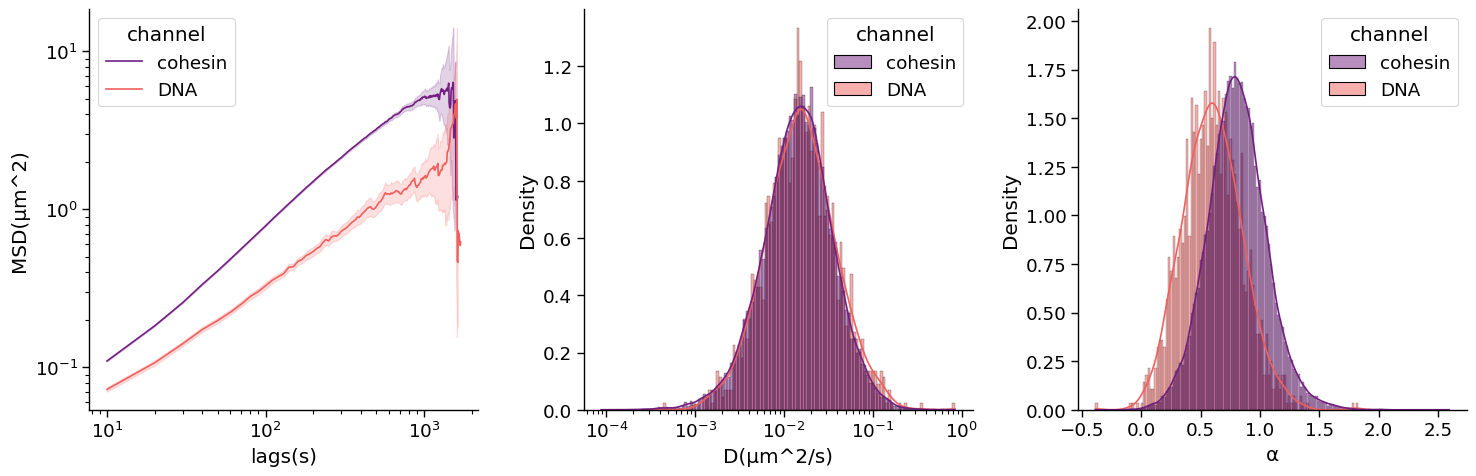

In [20]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
palette ='magma'
sns.histplot(data=coefficients_untreated, x=D, hue='channel', kde=True,fill=True, palette=palette,common_norm=False,log_scale=True,ax = ax[1],stat='density')
sns.histplot(data=coefficients_untreated, x=alpha, hue='channel', kde=True, fill=True, palette=palette,common_norm=False,ax = ax[2],stat='density')
sns.lineplot(data=df_untreated,x='lags(s)', y='MSD(µm^2)',hue='channel',palette=palette,ax=ax[0])

ax[0].set_yscale('log')
ax[0].set_xscale('log')
sns.despine(top=True,right=True)

fig.tight_layout()
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/master_thesis/plots/msd_DNA_cohesin.pdf',transparent=True)

# Figure 8

In [24]:
coefficients_sor_co = coefficients_sor[coefficients_sor.channel == 'cohesin']
coefficients_nip_co = coefficients_nip[coefficients_nip.channel == 'cohesin']
NIPBL_co = df_NIPBL[df_NIPBL.channel == 'cohesin']
sororin_co = df_sororin[df_sororin.channel == 'cohesin']

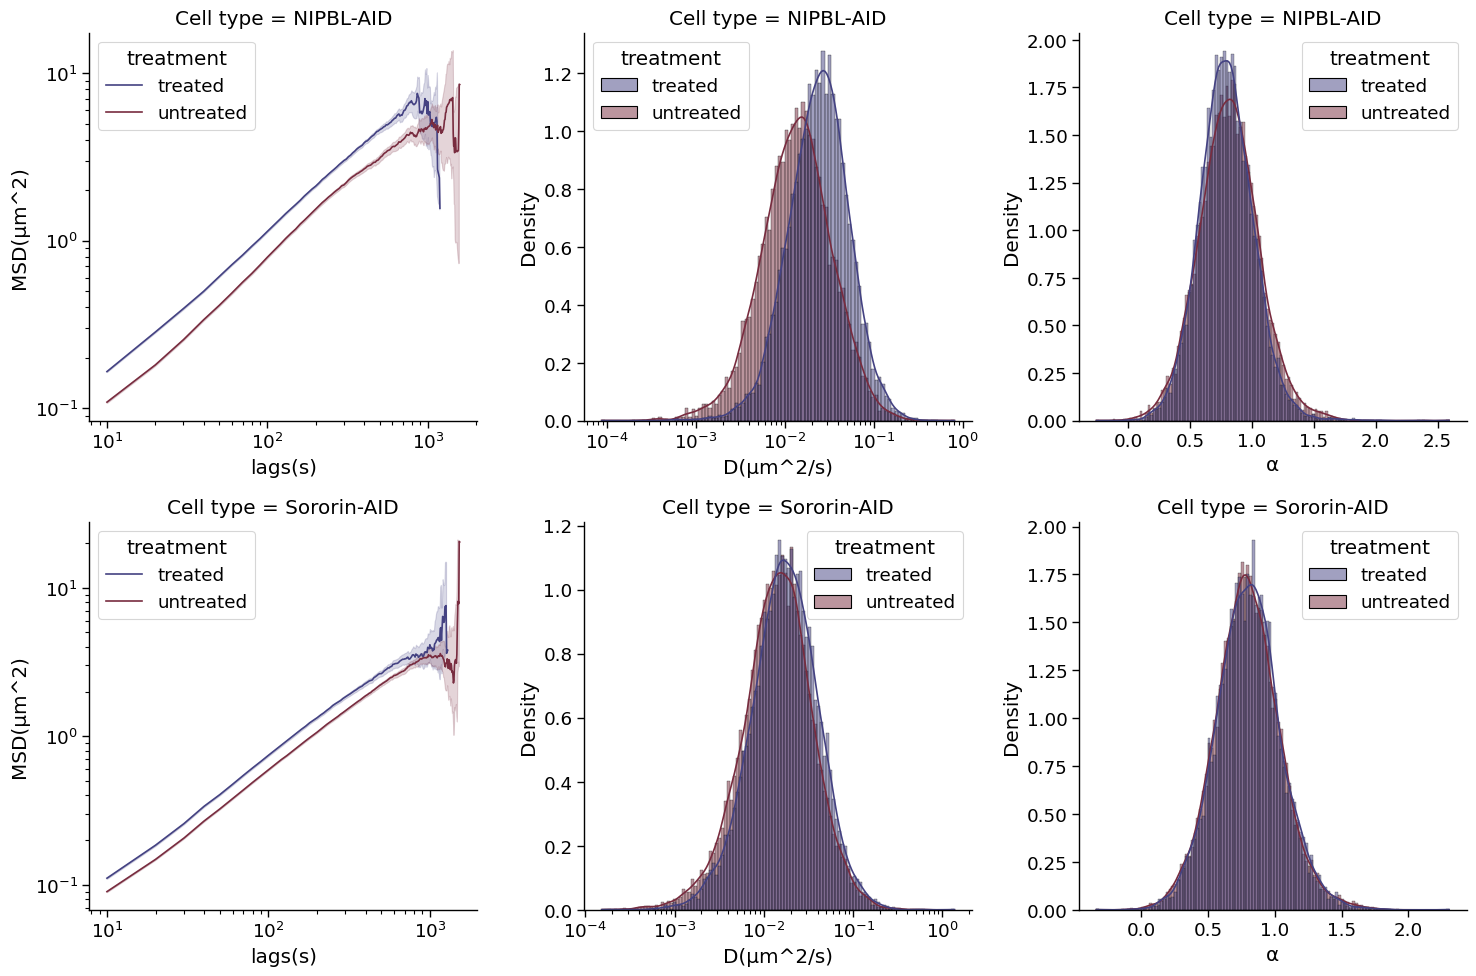

In [135]:
fig,ax = plt.subplots(2,3,figsize=(15,10))
ax = ax.ravel()

palette ='icefire'
sns.lineplot(data=NIPBL_co,x='lags(s)', y='MSD(µm^2)',hue='treatment',palette=palette,ax=ax[0])
sns.histplot(data=coefficients_nip_co, x=D, hue='treatment', kde=True,fill=True, palette=palette,common_norm=False,log_scale=True,ax = ax[1],stat='density')
sns.histplot(data=coefficients_nip_co, x=alpha, hue='treatment', kde=True, fill=True, palette=palette,common_norm=False,ax = ax[2],stat='density')


ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xscale('log')

sns.lineplot(data=sororin_co.sort_values(by='treatment'),x='lags(s)', y='MSD(µm^2)',hue='treatment',palette=palette,ax=ax[3])
sns.histplot(data=coefficients_sor_co.sort_values(by='treatment'), x=D, hue='treatment', kde=True,fill=True, palette=palette,common_norm=False,log_scale=True,ax = ax[4],stat='density')
sns.histplot(data=coefficients_sor_co.sort_values(by='treatment'), x=alpha, hue='treatment', kde=True, fill=True, palette=palette,common_norm=False,ax = ax[5],stat='density')



for l,a in enumerate(ax):
    if l < 3:
        a.set_title('Cell type = NIPBL-AID')
    else:
        a.set_title('Cell type = Sororin-AID')

sns.despine(top=True,right=True)

fig.tight_layout()
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/master_thesis/plots/cohesin_treatment.pdf',transparent=True)

# Stats

In [21]:
from scipy import stats

In [41]:
a = coefficients_nip_co[coefficients_nip_co['treatment'] == 'untreated'][D]
b = coefficients_nip_co[coefficients_nip_co['treatment'] == 'treated'][D]
p= stats.anderson(a,dist='norm')
print(p)
p= stats.anderson(b,dist='norm')
print(p)

AndersonResult(statistic=773.8063064650341, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=562.6022734673952, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [39]:
a = coefficients_untreated[coefficients_untreated['channel'] == 'DNA'][alpha]
b = coefficients_untreated[coefficients_untreated['channel'] == 'cohesin'][alpha]
p= stats.anderson(a,dist='norm')
print(p)
p= stats.anderson(b,dist='norm')
print(p)

AndersonResult(statistic=0.5906538887120405, critical_values=array([0.574, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=21.46086814624141, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [42]:
_,p = stats.bartlett(a,b)
p

1.616643176155083e-59

In [43]:
_,p = stats.ttest_ind(a,b,equal_var=False)
p

1.6619857597176134e-221

In [40]:
_,p = stats.mannwhitneyu(a,b)
p

2.3948778570709644e-186

In [31]:
print(a.median())
print(b.median())

0.012160802878588494
0.01585773448803683


In [160]:
print(coefficients_nip_co[coefficients_nip_co.treatment == 'treated'][D].median())

0.024498332052491568


In [162]:
coefficients_cohesin[coefficients_cohesin.treatment == 'untreated'][D].median()

0.014582786870937553

# Plot worklow

## Import data

In [11]:
df_NIPBL_untreated.file.unique()

array(['20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230526_Rad21-Halo_NIPBL_1C5_0h_3_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230526_Rad21-Halo_NIPBL_1C5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB'],
      dtype=object)

In [12]:
im = 3
im_w1 = imread(f'images/{df_NIPBL_untreated.file.unique()[im]}_w1.tif')
im_w2 = imread(f'images/{df_NIPBL_untreated.file.unique()[im]}_w2.tif')

In [13]:
im_w1_max = np.max(im_w1,axis=1)
im_w2_max = np.max(im_w2,axis=1) 

In [14]:
detection_w1 = pd.read_csv(f'results/{df_NIPBL_untreated.file.unique()[im]}/detections__{df_NIPBL_untreated.file.unique()[im]}__w1.csv')
detection_w2 = pd.read_csv(f'results/{df_NIPBL_untreated.file.unique()[im]}/detections__{df_NIPBL_untreated.file.unique()[im]}__w2.csv')

In [15]:
labels = np.load(f'results/{df_NIPBL_untreated.file.unique()[im]}/labels__{df_NIPBL_untreated.file.unique()[im]}__w2.npy')

In [16]:
tracks = pd.read_csv(f'results/{df_NIPBL_untreated.file.unique()[im]}/tracks_corrected__{df_NIPBL_untreated.file.unique()[im]}.csv')

In [82]:
tracks_unc = pd.read_csv(f'results/{df_NIPBL_untreated.file.unique()[im]}/tracks_merged__{df_NIPBL_untreated.file.unique()[im]}.csv')

## Plot

In [44]:
detection_w1[detection_w1.frame == 0]

,y,x,sd_fit_x,sd_fit_y,frame,z
0,2.142004e-12,292.271110,0.184693,0.464406,0,0
1,4.216902e+00,91.983652,0.260324,0.310934,0,0
2,3.646135e+00,304.649383,0.066335,0.066204,0,0
3,5.203972e+00,237.884839,0.118531,0.150447,0,0
4,5.097358e+00,311.017917,0.207567,0.220477,0,0
...,...,...,...,...,...,...
1832,4.657412e+02,126.668690,0.124297,0.259514,0,4
1833,4.644446e+02,139.490272,0.114873,0.115709,0,4
1834,4.780131e+02,88.155230,0.184832,0.166920,0,4
1835,4.850736e+02,456.485754,0.311252,0.227976,0,4


In [18]:
frame = 0

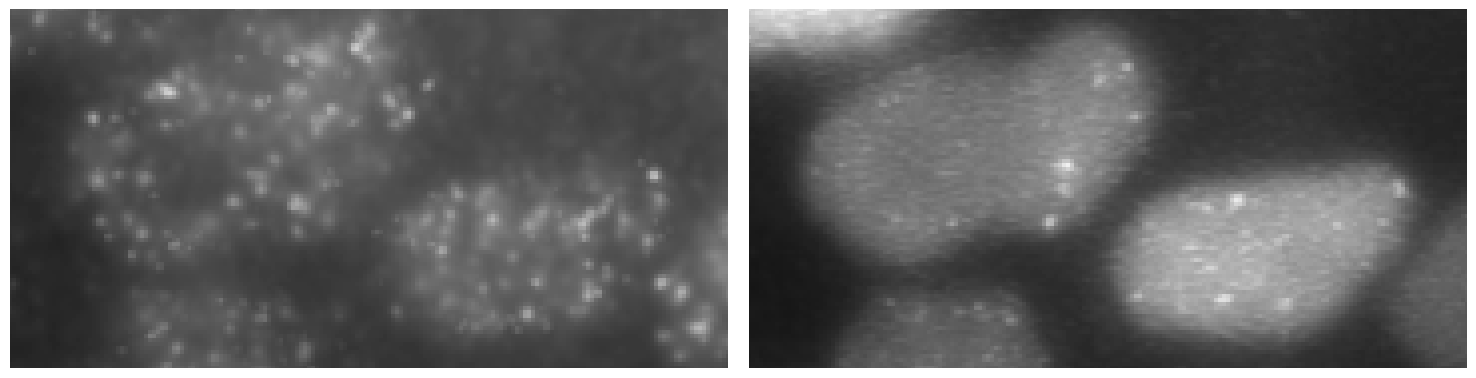

In [71]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].imshow(im_w1_max[frame,...],cmap='gray',vmin=12_000,vmax=37_000)
ax[1].imshow(im_w2_max[frame,...],cmap='gray',vmin=1_000,vmax=20_000)

xmin,xmax,ymin,ymax = 120,300,160,250
for l,a in enumerate(ax):
    # a.set_title(title[l])
    a.axis('off')
    a.set_xlim(xmin,xmax)
    a.set_ylim(ymin,ymax)

fig.tight_layout()
plt.savefig('plots/example_channels.jpeg',dpi=600)


In [47]:
tracks

,Unnamed: 0.1,Unnamed: 0,x,y,frame,track_id,label,channel,z,xres,yres,zres,degree_av_rotation,degree_av_translation
0,99,131,204.283847,133.851330,0,131,1,w1,0.0,0.000000,0.000000,0.0,0.023033,5.647143
1,101,133,167.280731,134.964334,0,133,1,w1,0.0,0.000000,0.000000,0.0,0.023033,5.647143
2,102,134,182.447341,135.200686,0,134,1,w1,0.0,0.000000,0.000000,0.0,0.023033,5.647143
3,114,148,158.804591,142.762665,0,148,1,w1,0.0,0.000000,0.000000,0.0,0.023033,5.647143
4,115,149,172.000752,142.775550,0,149,1,w1,0.0,0.000000,0.000000,0.0,0.023033,5.647143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187824,186897,213968,285.680402,72.572978,178,23557,107,w1,0.0,-2.896890,-1.296656,0.0,0.225519,67.292925
187825,187019,214128,282.655278,77.586777,178,24476,107,w1,0.0,-4.094641,-1.846153,0.0,0.225519,67.292925
187826,187229,214420,301.251513,51.675019,178,24456,107,w1,0.0,2.170451,1.656067,0.0,0.225519,67.292925
187827,187230,214421,282.437656,49.410786,178,24032,107,w1,0.0,2.200359,-2.608286,0.0,0.225519,67.292925


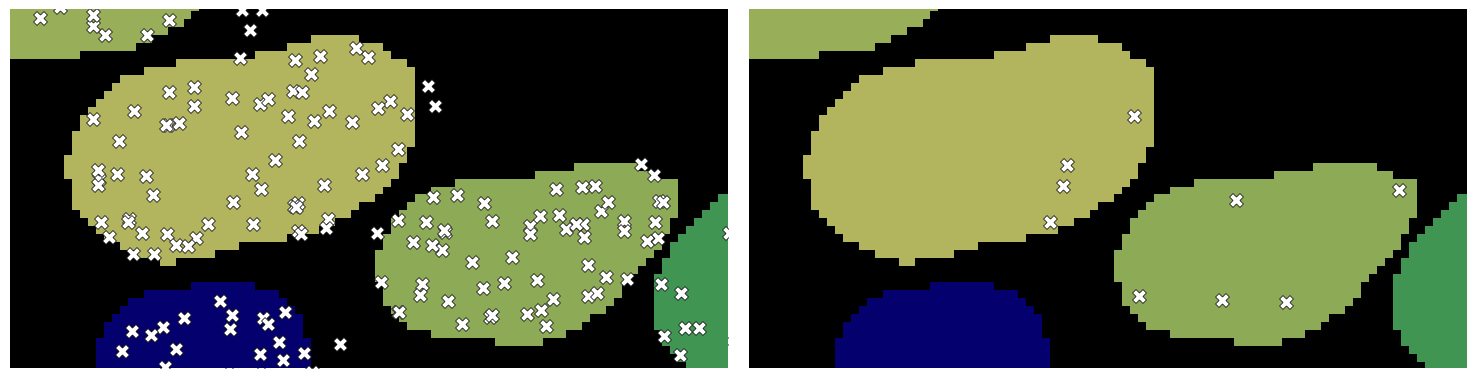

In [80]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].imshow(labels[frame,...],interpolation='nearest',cmap='gist_earth')#,cmap='gray',vmin=12_000,vmax=37_000)
ax[1].imshow(labels[frame,...],interpolation='nearest',cmap='gist_earth')#,cmap='gray',vmin=1_000,vmax=20_000)

sns.scatterplot(data=tracks[(tracks.frame == frame)&(tracks.channel=='w1')],x='x',y='y',marker='X',ax=ax[0],s=100,linewidth=0.5,c='white',edgecolor='black')
sns.scatterplot(data=tracks[(tracks.frame == frame)&(tracks.channel=='w2')],x='x',y='y',marker='X',ax=ax[1],s=100,linewidth=0.5,c='white',edgecolor='black')

xmin,xmax,ymin,ymax = 120,300,160,250

for l,a in enumerate(ax):
    # a.set_title(title[l])
    a.axis('off')
    a.set_xlim(xmin,xmax)
    a.set_ylim(ymin,ymax)

fig.tight_layout()
plt.savefig('plots/example_channels_spots.jpeg',dpi=600)


In [108]:
np.unique(labels[frame,ymin:ymax,xmin:xmax])

array([ 0,  6,  8, 15, 18, 23, 30, 32, 34], dtype=int32)

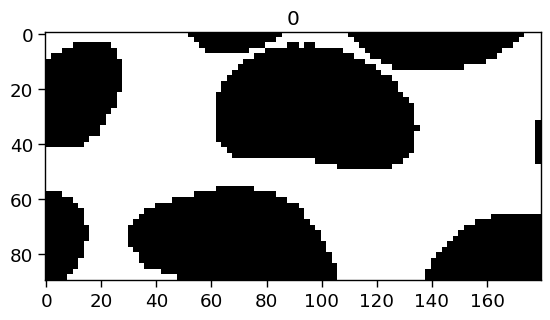

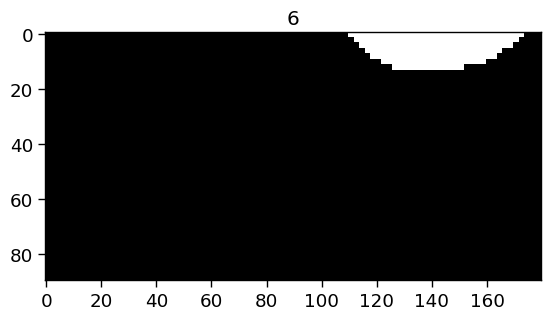

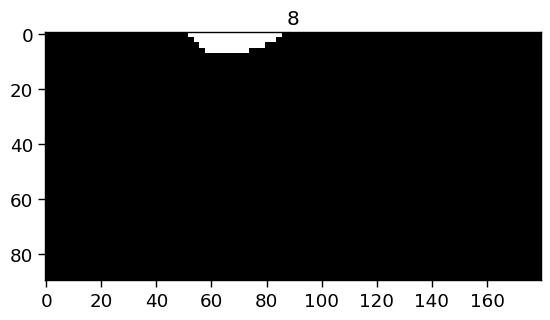

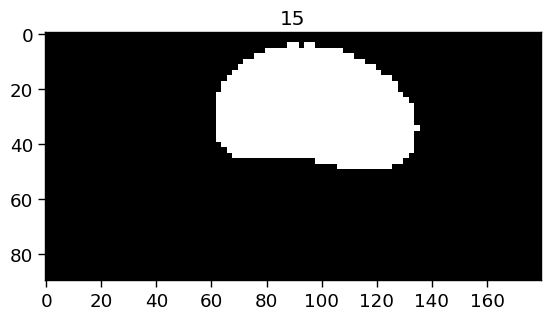

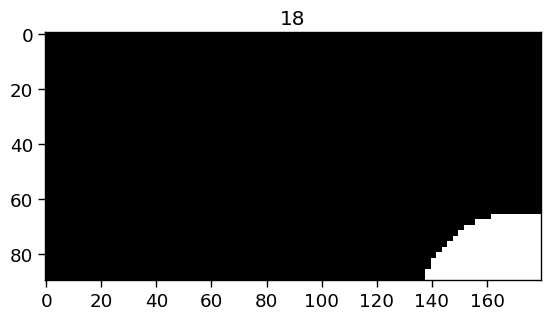

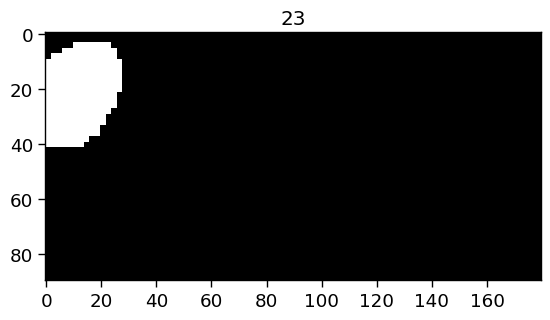

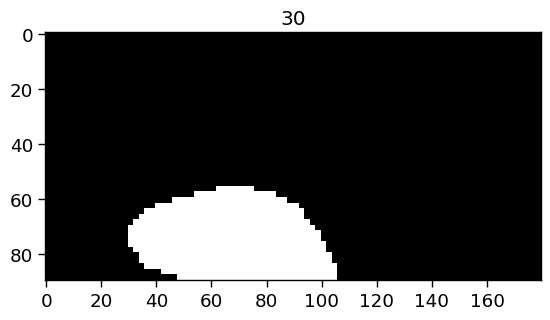

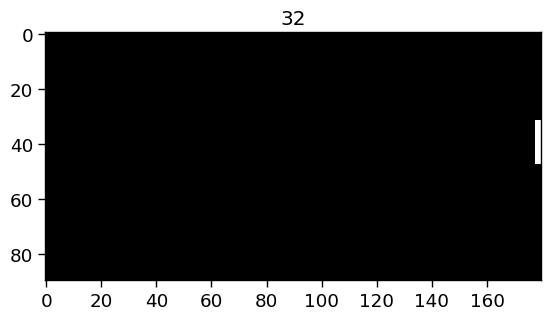

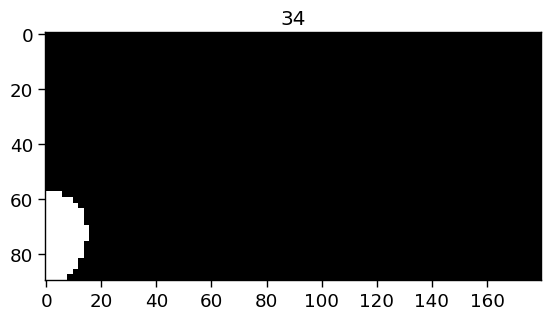

In [111]:
for i in np.unique(labels[frame,ymin:ymax,xmin:xmax]):
    l = labels == i
    plt.imshow(l[frame,ymin:ymax,xmin:xmax],interpolation='nearest',cmap='gray')
    plt.title(i)
    plt.show()

In [126]:
l = labels == 15
f = labels == 18
d = labels == 23
g = labels == 30
h = labels == 34

i = l | g | h | d | f

(160.0, 250.0)

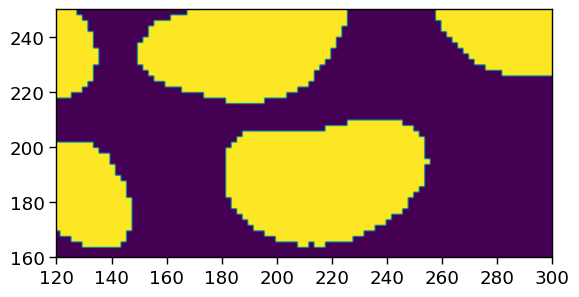

In [128]:
plt.imshow(i[frame])
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

In [164]:
tracks_w1 = tracks[(tracks.channel=='w1')&(tracks.label == 15)].groupby('track_id').size().sort_values(ascending=False).head(5).index
tracks_w2 = tracks[(tracks.channel=='w2')&(tracks.label == 15)].groupby('track_id').size().sort_values(ascending=False).head(5).index

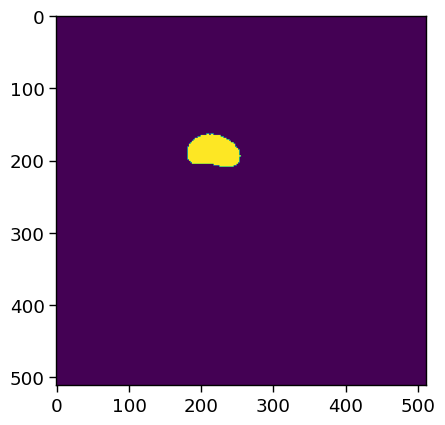

In [162]:
l = labels == 15

plt.imshow(l[frame])

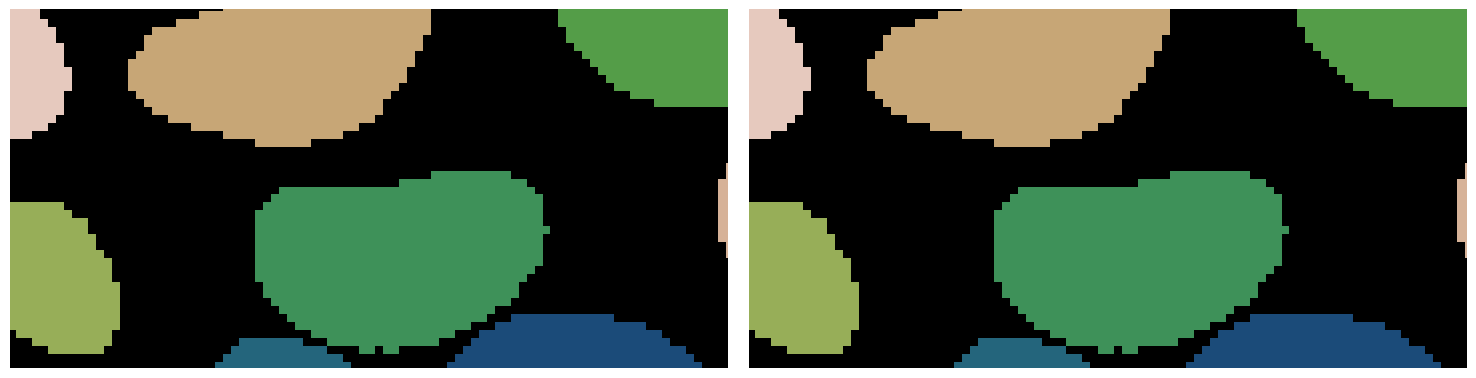

In [170]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

frame =180

ax[0].imshow(labels[frame,...],interpolation='nearest',cmap='gist_earth')#,cmap='gray',vmin=12_000,vmax=37_000)
ax[1].imshow(labels[frame,...],interpolation='nearest',cmap='gist_earth')#,cmap='gray',vmin=1_000,vmax=20_000)

# for i,j in zip(tracks_w1,tracks_w2):
#     sns.scatterplot(data=tracks_unc[(tracks_unc.channel=='w1')&(tracks_unc.track_id==i)],x='x',y='y',marker='X',ax=ax[0],s=100,hue='frame',legend=False)
#     sns.scatterplot(data=tracks_unc[(tracks_unc.channel=='w2')&(tracks_unc.track_id==j)],x='x',y='y',marker='X',ax=ax[1],s=100,hue='frame',legend=False)

xmin,xmax,ymin,ymax = 120,300,160,250

for l,a in enumerate(ax):
    # a.set_title(title[l])
    a.axis('off')
    a.set_xlim(xmin,xmax)
    a.set_ylim(ymin,ymax)

fig.tight_layout()
plt.savefig('plots/example_channels_labels.jpeg',dpi=600)


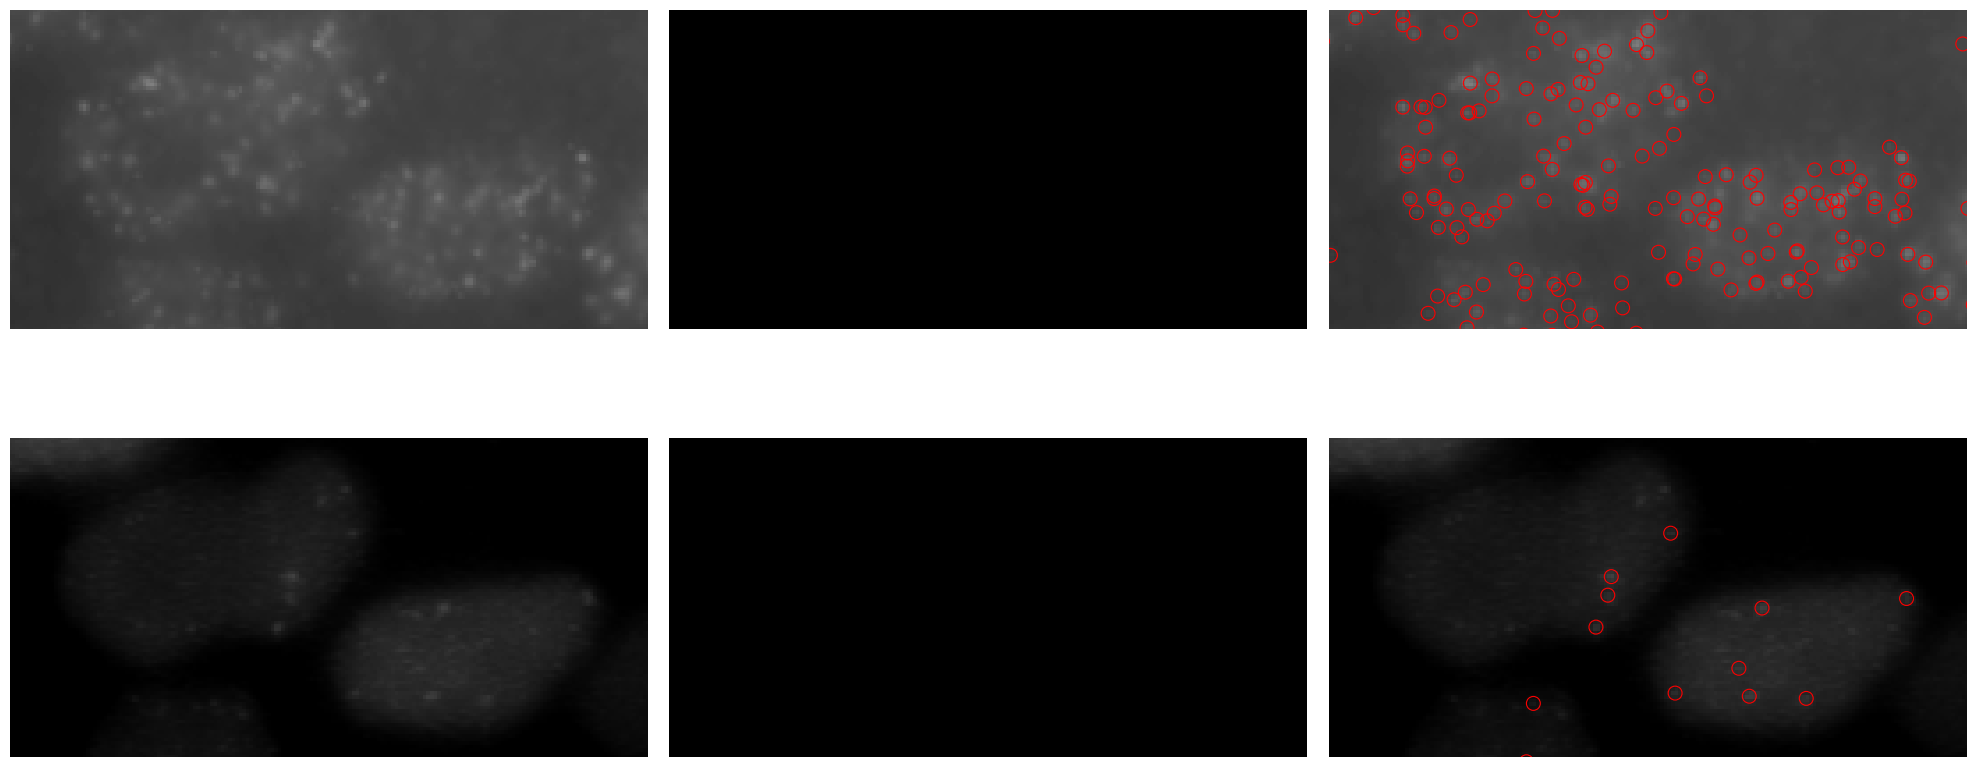

In [68]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.ravel()



for im,a in zip([im_w1_max,labels,im_w1_max,im_w2_max,labels,im_w2_max],ax):
    a.imshow(im[frame,...],cmap='gray',vmin=5_000,vmax=60_000)

sns.scatterplot(data=detection_w1[detection_w1.frame == frame],x='x',y='y',facecolors='none',edgecolor='red',ax=ax[2],s=100)
sns.scatterplot(data=detection_w2[detection_w2.frame == frame],x='x',y='y',facecolors='none',edgecolor='red',ax=ax[-1],s=100)

xmin,xmax,ymin,ymax = 120,300,160,250
for l,a in enumerate(ax):
    # a.set_title(title[l])
    a.axis('off')
    a.set_xlim(xmin,xmax)
    a.set_ylim(ymin,ymax)

fig.tight_layout()


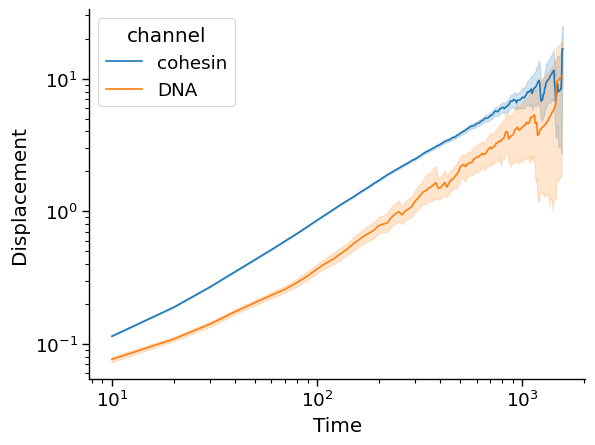

In [174]:
sns.lineplot(df_NIPBL_untreated,x='lags(s)', y='MSD(µm^2)',hue='channel')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Displacement')
plt.xlabel('Time')
sns.despine(top=True,right=True)
plt.savefig('plots/MSD_NIPBL_untreated_example.jpeg',dpi=600,transparent=True)